### Basic Imports

In [1]:
import numpy as np
import pandas as pd
import os
import sys


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion


from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
%matplotlib inline

### Loading Data

In [2]:
#set relative path to data
DATA_PATH = os.path.join("../data/")

#true to load in training data
def load_movie_reviews(path=DATA_PATH, train=True):
    if train:
        tsv_path = os.path.join(path, "labeledTrainData.tsv")
    else:
        tsv_path = os.path.join(path, "testData.tsv")
    return pd.read_csv(tsv_path, delimiter='\t', header=0, quoting=3)

In [3]:
#load train data
review_train_orig = load_movie_reviews(path=DATA_PATH, train=True)
review_train = review_train_orig.copy()

#load test data
review_test_orig = load_movie_reviews(path=DATA_PATH, train=False)
review_test = review_test_orig.copy()

In [4]:
review_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB


In [5]:
review_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


***Note:*** we need to remember to add in the 'sentiment' for the test data set based on the 'id' column

### Adding 'sentiment' To Test Data

In [6]:
def add_sentiment(df):
    sentiment = [1 if int(x[1].strip('"')) >= 5 else 0 for x in df['id'].str.split('_')]
    df['sentiment'] = sentiment
    return

#adding sentiment column to test data
add_sentiment(review_test)
review_test.head()

,id,review,sentiment
0,"""12311_10""","""Naturally in a film who's main themes are of ...",1
1,"""8348_2""","""This movie is a disaster within a disaster fi...",0
2,"""5828_4""","""All in all, this is a movie for kids. We saw ...",0
3,"""7186_2""","""Afraid of the Dark left me with the impressio...",0
4,"""12128_7""","""A very accurate depiction of small time mob l...",1


### Extracting Train and Test Output Columns

In [7]:
y_train = review_train['sentiment'].values
y_test  = review_test['sentiment'].values 

### Custom Classes

In [8]:
class modelScorer():
    def __init__(self, title, model, y, X):
        """
        title --> string --> describe the model (used for book keeping)
        model --> sklearn model
        y     --> np array --> target output column from feature matrix 
        X     --> np array --> feature matrix
        """
        self.title = title
        self.model = model
        self.y = y
        self.X = X
        
        self.y_predict = self.model.predict(self.X)
        
        self.confusion_matrx = confusion_matrix(self.y, self.y_predict)
        self.accuracy_scr = accuracy_score(self.y, self.y_predict)
        self.recall_scr = recall_score(self.y, self.y_predict)
        self.precision_scr = precision_score(self.y, self.y_predict)
        
    def genScoreReport(self):
        print("\t\tSCORE FOR {}".format(self.title))
        print("Accuracy:{0:.2f}".format(self.accuracy_scr))
        print("Recall:{0:.2f}".format(self.recall_scr))
        print("Precision:{0:.2f}".format(self.precision_scr))
        print("\nConfusion Matrix:\n {}".format(self.confusion_matrx))
        
    def plot_roc(self):
        AUC = roc_auc_score(self.y, self.model.predict_proba(self.X)[:,1])
        fpr, tpr, thresholds = roc_curve(self.y, self.model.predict_proba(self.X)[:,1])
    
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % AUC)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic:: {}'.format(self.title))
        plt.legend(loc="lower right");
        
    def getAccuracyScore(self):
        return self.accuracy_scr
    
    def getRecallScore(self):
        return self.recall_scr
    
    def getPrecisionScore(self):
        return self.precision_scr
    
    def getConfusionMatrix(self):
        return self.confusion_matrx

### Preprocessing Reviews

In [9]:
def review_cleaner(reviews):
    #remove all integers from reviews
    reviews['review'] = reviews['review'].str.replace(pat='[0-9]+', repl='')
    #remove all HTML tags from reviews
    reviews['review'] = reviews['review'].str.replace(pat='<[^<]+?>', repl='')
    temp = reviews.drop(['id', 'sentiment'], axis=1)
    return temp.values.ravel()
    
X_train = review_cleaner(review_train)
X_test = review_cleaner(review_test)

In [10]:
y_train.shape, X_train.shape

((25000,), (25000,))

### Logistic Regression

In [11]:
logistic_pipe = make_pipeline(CountVectorizer(), LogisticRegression())

param_grid = {
                'logisticregression__C':[0.1],
                'countvectorizer__stop_words':['english'],
                'countvectorizer__lowercase':[True],
                'countvectorizer__max_features':[2000]
             }
                              
clf = GridSearchCV(logistic_pipe, param_grid,  cv=10)
clf.fit(X_train, y_train);

In [12]:
clf.best_params_

{'countvectorizer__lowercase': True,
 'countvectorizer__max_features': 2000,
 'countvectorizer__stop_words': 'english',
 'logisticregression__C': 0.1}

In [13]:
logistic_test_score = modelScorer("Logistic --> Test", clf, y_test, X_test)
logistic_train_score = modelScorer("Logistic --> Train", clf, y_train, X_train)

In [14]:
logistic_test_score.genScoreReport()

		SCORE FOR Logistic --> Test
Accuracy:0.87
Recall:0.87
Precision:0.86

Confusion Matrix:
 [[10715  1785]
 [ 1587 10913]]


In [15]:
logistic_train_score.genScoreReport()

		SCORE FOR Logistic --> Train
Accuracy:0.90
Recall:0.91
Precision:0.89

Confusion Matrix:
 [[11159  1341]
 [ 1150 11350]]


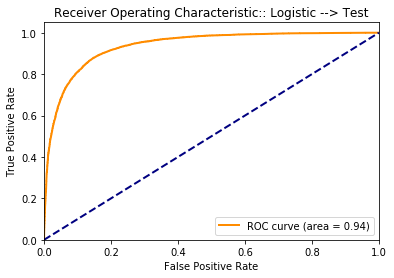

In [16]:
logistic_test_score.plot_roc()

### Random Forest

In [17]:
rf_pipe = make_pipeline(CountVectorizer(), RandomForestClassifier(n_jobs=-1, n_estimators=2000, max_features='log2'))

param_grid = {
                'countvectorizer__stop_words':['english'],
                'countvectorizer__lowercase':[True],
                'countvectorizer__max_features':[2000]
             }
                              
clf = GridSearchCV(rf_pipe, param_grid,  cv=10)
clf.fit(X_train, y_train);

In [18]:
clf.best_params_

{'countvectorizer__lowercase': True,
 'countvectorizer__max_features': 2000,
 'countvectorizer__stop_words': 'english'}

In [19]:
rf_test_score = modelScorer("Logistic --> Test", clf, y_test, X_test)
rf_train_score = modelScorer("Logistic --> Train", clf, y_train, X_train)

In [20]:
rf_test_score.genScoreReport()

		SCORE FOR Logistic --> Test
Accuracy:0.86
Recall:0.86
Precision:0.86

Confusion Matrix:
 [[10760  1740]
 [ 1721 10779]]


In [21]:
rf_train_score.genScoreReport()

		SCORE FOR Logistic --> Train
Accuracy:1.00
Recall:1.00
Precision:1.00

Confusion Matrix:
 [[12500     0]
 [    0 12500]]


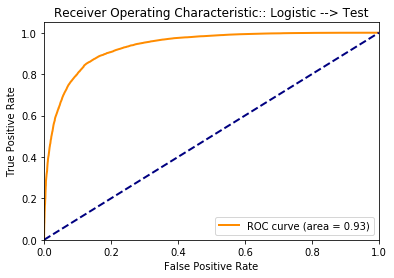

In [22]:
rf_test_score.plot_roc()